Lo primero que se hace es cargar todas las librerias y módulos que se van a utilizar

In [127]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt

from math import sqrt

import eli5
from eli5.sklearn import PermutationImportance

import xgboost as xgb
from xgboost import plot_importance

import pdb

Cargamos los datos con la librería pandas para manejar el dataset fácilmente

In [3]:
df = pd.read_csv('dataset.csv')
df.shape

(50, 7)

**EDA**

Mostramos la cabecera de los datos y un resumen de los datos para ver información básica de cada variable

In [4]:
df.head()

,property_transactions,mortgages_amount,consumer_price_index,gross_income,unemployment_rate,construction_workers,property_price_index
0,70548.0,3.586918e+09,104.824,3.088850e+11,14.02,1270200.0,124.175
1,75655.0,3.849970e+09,103.698,3.038740e+11,14.70,1295900.0,122.758
2,59764.0,2.697364e+09,104.405,3.023070e+11,14.45,1277600.0,120.954
3,74851.0,4.229837e+09,104.029,2.988170e+11,14.55,1228400.0,120.491
4,76049.0,3.818936e+09,104.376,2.972050e+11,15.28,1213200.0,117.941


In [5]:
df.describe()

,property_transactions,mortgages_amount,consumer_price_index,gross_income,unemployment_rate,construction_workers,property_price_index
count,50.00000,5.000000e+01,50.000000,5.000000e+01,50.000000,5.000000e+01,50.000000
mean,64052.32000,4.704341e+09,98.116480,2.673742e+11,18.820600,1.480714e+06,119.249500
std,20516.65798,3.799715e+09,4.543268,1.622420e+10,5.294338,5.609719e+05,18.539357
min,39824.00000,1.252198e+09,87.747000,2.495220e+11,7.930000,9.725000e+05,95.208000
25%,48369.75000,2.300314e+09,93.931250,2.560105e+11,15.555000,1.078450e+06,102.979500
50%,60683.00000,3.325462e+09,99.850000,2.612280e+11,19.715000,1.218600e+06,116.467500
75%,71777.25000,6.309909e+09,101.278750,2.745838e+11,23.392500,1.694675e+06,135.891250
max,138804.00000,1.714641e+10,104.824000,3.088850e+11,26.940000,2.761700e+06,151.719000


Se puede ver que todas las variables son contínuas, incluida la variable de salida. Por lo tanto, estamos tratando un problema de regresión. 

Miramos los datos faltantes del dataset para ver si es necesario tratarlos

In [6]:
df.isna().sum()

property_transactions    0
mortgages_amount         0
consumer_price_index     0
gross_income             0
unemployment_rate        0
construction_workers     0
property_price_index     0
dtype: int64

Como se puede ver, no hay ningún dato faltante, por lo que no hace falta hacer nada en este aspecto

Se va a ver el coeficiente de correlación de pearson entre las variables. Esto es muy importante, sobre todo en problemas como regresión, donde se quiere que los predictores tengan una correlación alta con la variable de salida, y entre ellos tengan poca a su vez.

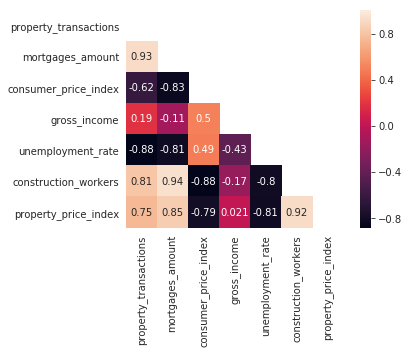

In [7]:
corr_matrix = df.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corr_matrix, annot=True, square=True, mask=mask)

Se puede ver como todas las variables tienen una correlación alta con la variable de salida, excepto *gross income*. Hay un problema, y es que hay mucha correlación entre los predictores, lo que puede dar lugar a problemas en el entrenamiento. 

A continuación, se va a mostrar un scatterplot para cada par de variables:

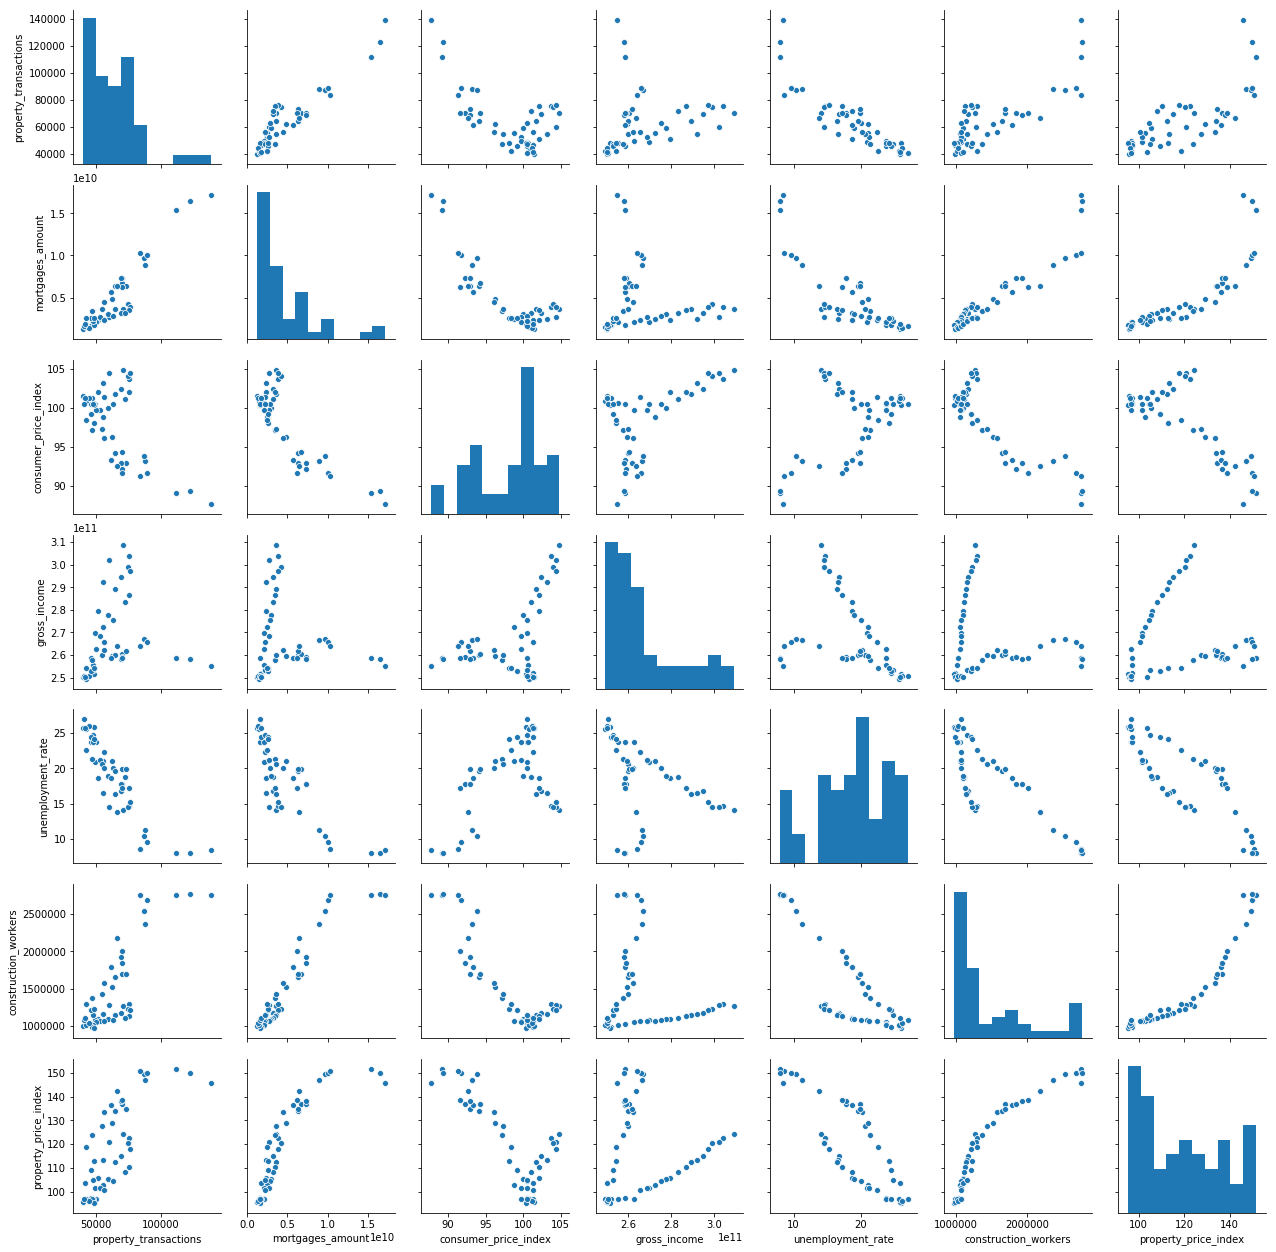

In [9]:
sns.pairplot(df)

A simple vista, las variables más correladas con la variable de salida se puede ver que son *construction_workers* y *mortgages_amount*. Sin embargo, la correlación entre ellas a su vez también es alta. Se puede ver como en algunos pares hay claramente *outliers* o valores anómalos, por lo que va a ser necesario una preprocesamiento acorde a ello. 

Por último en este apartado, se va a mostrar la distribución de la variable de salida para ver si es necesaria la transformación:

/home/eduardo/DL_Environment/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


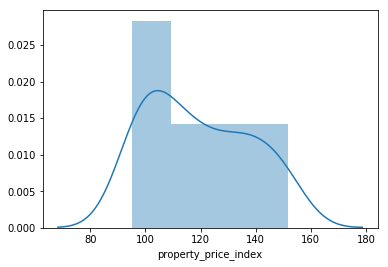

In [10]:
sns.distplot(df['property_price_index'])

Se puede ver que la distribución está un poco skewed hacia la derecha. No se hace ninguna transformación porque son muy pocos datos y solo hay más valores en un rango pequeño de los datos, por lo que no se espera que mejore prácticamente. 

**MODELOS**

Como métrica en este problema de regresión se va a usar el RMSE. Se va a usar sklearn para hacer más fácil el cálcula de esta métrica:

In [11]:
def rmse(actual_y, pred_y):
    return sqrt(mean_squared_error(actual_y, pred_y))

Para cada modelo el preprocesamiento puede variar, por lo que se hará por separado. En todos se partirá el dataset en un 80% train y 20% test. No se va a hacer un *hold-out* ni un *k-fold* por la falta de datos. Se van a mostrar los modelos probados por orden y el preprocesamiento hecho en cada uno según los resultados.

*Regresión lineal*

Lo primero que se ha hecho ha sido probar con una regresión lineal simple, para ver el resultado. Este algoritmo prefiere tener predictores correlados con la variable de salida pero no entre ellos. Primeramente se va a probar con todas las variables. Hay que señalar que en el particionamiento de los datos, no se mezclan los ejemplos para meterlos en cada partición, ya que estos están ordenados cronológicamente. 

In [20]:
X = df.drop(['property_price_index'], axis=1)
X_col = X.columns.tolist()
y = df['property_price_index']
train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=False, test_size=0.20)
train_x.shape, test_x.shape

((40, 6), (10, 6))

In [21]:
lm = LinearRegression().fit(train_x, train_y)
pred_y_train = lm.predict(train_x)
pred_y_test = lm.predict(test_x)
rmse(train_y, pred_y_train), rmse(test_y, pred_y_test)

(2.5570170470815605, 40.76652092177185)

La diferencia de rmse entre en train y test es muy grande, lo que indica que hay un claro overfitting. Se va a usar la librería eli5 para ver como afectan las variables positivamente (color verde) y negativamente (color rojo) en el modelo:

In [23]:
perm = PermutationImportance(lm, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = X_col,top=10)

Weight,Feature
12.7760 ± 10.6278,construction_workers
7.2995 ± 3.5095,mortgages_amount
0.5744 ± 0.9111,consumer_price_index
-0.0174 ± 0.0259,gross_income
-0.6982 ± 0.9130,property_transactions
-3.0369 ± 0.6745,unemployment_rate


Como se ha visto en la EDA, las mejores variables son *construction_workers* y *mortgages_amount*, ya que tienen una alta correlación con la variable de salida. Las variables en rojo se puede ver como no tienen una correlación muy limpia para aplicarse con una regresión lineal. Se van a quitar estas variables y añadir la variable *construction_workers* elevada al cuadrado ya que puede ayudar a la regresión lineal a ajustarse mejor a la variable de salida:

In [27]:
X = df.drop(['property_price_index', 'unemployment_rate', 'property_transactions'], axis=1)
X['construction_workers_2'] = X['construction_workers'] ** 2
X_col = X.columns.tolist()
y = df['property_price_index']
train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=False, test_size=0.20)
train_x.shape, test_x.shape

((40, 5), (10, 5))

In [28]:
lm = LinearRegression().fit(train_x, train_y)
pred_y_train = lm.predict(train_x)
pred_y_test = lm.predict(test_x)
rmse(train_y, pred_y_train), rmse(test_y, pred_y_test)

(1.6426166997050031, 30.403815819326127)

In [29]:
perm = PermutationImportance(lm, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = X_col,top=10)

Weight,Feature
439.8609 ± 214.2798,construction_workers_2
403.1614 ± 354.2554,construction_workers
4.0372 ± 0.8879,mortgages_amount
0.0512 ± 0.3744,gross_income
-0.6850 ± 0.7449,consumer_price_index


Se puede ver como este cambio en el preprocesamiento mejora el rmse en test por 10 puntos aproximadamente. Sin embargo, el overfitting sigue siendo muy grande. 

*Random Forest*

Ahora se va a probar con el famoso algoritmo basado en árboles a modo ensemble *Random Forest*. Se van a probar unos parámetros acordes para evitar el overfitting. Por ejemplo, una profundidad máxima del árbol reducida, para crear árboles más simples:

In [47]:
X = df.drop(['property_price_index'], axis=1)
y = df['property_price_index']
X_col = X.columns.tolist()
train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=False, test_size=0.20)
train_x.shape, test_x.shape

((40, 6), (10, 6))

In [48]:
rf = RandomForestRegressor(max_depth=4, n_estimators=300, min_samples_leaf=2, random_state=0).fit(train_x, train_y)
pred_y_train = rf.predict(train_x)
pred_y_test = rf.predict(test_x)
rmse(train_y, pred_y_train), rmse(test_y, pred_y_test)

(1.134055002654223, 11.76485927048467)

In [49]:
perm = PermutationImportance(rf, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = X_col,top=10)

Weight,Feature
0.0584 ± 0.0234,mortgages_amount
0.0010 ± 0.0148,property_transactions
0 ± 0.0000,construction_workers
-0.0040 ± 0.0108,consumer_price_index
-0.0099 ± 0.0031,unemployment_rate
-0.0174 ± 0.0175,gross_income


Se puede ver como el rmse mejora claramente en test respecto a la regresión lineal. Se van a quitar las variables que afectan negativamente según eli5:

In [57]:
X = df.drop(['property_price_index', 'gross_income', 'unemployment_rate'], axis=1)
y = df['property_price_index']
X_col = X.columns.tolist()
train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=False, test_size=0.20)
train_x.shape, test_x.shape

((40, 4), (10, 4))

In [58]:
rf = RandomForestRegressor(max_depth=4, n_estimators=300, min_samples_leaf=2, random_state=0).fit(train_x, train_y)
pred_y_train = rf.predict(train_x)
pred_y_test = rf.predict(test_x)
rmse(train_y, pred_y_train), rmse(test_y, pred_y_test)

(1.213280346333125, 11.603193357322475)

In [59]:
perm = PermutationImportance(rf, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = X_col,top=10)

Weight,Feature
0.0713 ± 0.0419,mortgages_amount
0 ± 0.0000,construction_workers
-0.0029 ± 0.0079,property_transactions
-0.0060 ± 0.0092,consumer_price_index


Se puede ver como el rmse mejora algo, y además se hace el modelo más simple. Pero por desgracia, el overfitting sigue siendo bastante alto.

*XGBoost*

Se va a probar con uno de los algoritmos más famosos de boosting. Se elige este porque hace menos overfitting con pocos datos que otros como LightGBM. Sin embargo, siguen siendo muy pocos datos para que un algoritmo de boosting que se basa en iteraciones no haga overfitting. Se va a intentar evitar esto con el uso de regularización y el parámetro *early_stopping_rounds* para que deje de entrenar una vez que no mejore en test el resultado:

In [93]:
X = df.drop(['property_price_index'], axis=1)
y = df['property_price_index']
X_col = X.columns.tolist()
train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=False, test_size=0.20)
train_x.shape, test_x.shape

((40, 6), (10, 6))

In [95]:
xgb_model = xgb.XGBRegressor(objective="reg:linear",
                             random_state=42,
                             n_estimators=1000,
                             max_depth=4,
                             learning_rate=0.03,
                             reg_alpha = 0.1,
                             eval_set=[(train_x, train_y), (test_x, test_y)],
                             early_stopping_rounds=50)
xgb_model.fit(train_x, train_y)
pred_y_train = xgb_model.predict(train_x)
pred_y_test = xgb_model.predict(test_x)
rmse(train_y, pred_y_train), rmse(test_y, pred_y_test)

(0.03883960203789441, 12.134920167200944)

In [96]:
perm = PermutationImportance(xgb_model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = X_col,top=10)

Weight,Feature
0.0304 ± 0.0108,mortgages_amount
0.0000 ± 0.0000,consumer_price_index
0 ± 0.0000,construction_workers
-0.0038 ± 0.0048,gross_income
-0.0092 ± 0.0031,unemployment_rate
-0.2566 ± 0.1819,property_transactions


Se obtienen un resultado parecido a Random Forest, aunque un poco peor en cuanto al rmse en test y más overfitting todavía, ya que el rmse del conjunto de entrenamiento es casi nulo. En la importancia de variables, parece que la única variable que ayuda es *mortgages_amount*. Por ello, se va a probar dejar solo las 2 variables que hemos dicho en la EDA que eran las mejores:

In [100]:
X = df.drop(['property_price_index', 'property_transactions', 'gross_income', 'consumer_price_index', 'unemployment_rate'], axis=1)
y = df['property_price_index']
X_col = X.columns.tolist()
train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=False, test_size=0.20)
train_x.shape, test_x.shape

((40, 2), (10, 2))

In [101]:
xgb_model = xgb.XGBRegressor(objective="reg:linear",
                             random_state=42,
                             n_estimators=1000,
                             max_depth=4,
                             learning_rate=0.03,
                             reg_alpha = 0.1,
                             eval_set=[(train_x, train_y), (test_x, test_y)],
                             early_stopping_rounds=50)
xgb_model.fit(train_x, train_y)
pred_y_train = xgb_model.predict(train_x)
pred_y_test = xgb_model.predict(test_x)
rmse(train_y, pred_y_train), rmse(test_y, pred_y_test)

(0.06617511249871486, 10.813511474733561)

Se puede ver como el rmse disminuye en test además de que el modelo es mucho más simple por solo tener 2 predictores. Ahora, si tuvieramos que elegir entre el modelo Random Forest y este, consideraría mejor Random Forest porque el overfitting no es tan drástico y la diferencia en el rmse del conjunto de test es mínima. De todas formas, todos los modelos vistos hasta ahora no son buenos ya que todos provocan un alto overfitting.

*Regresión Lasso*

Se va a probar con un regresor que es muy robusto al overfitting y no le afectan tanto las correlaciones entre los predictores, por lo que, según la teoría, es perfecto para este problema. Para evitar el overfitting se va a poner un parámetro alpha relativamente alto. Además, se escalan los datos de forma robusta ya que Lasso es sensible a *outliers*

In [118]:
X = df.drop(['property_price_index'], axis=1)
X_cols = X.columns.tolist()
X = RobustScaler().fit_transform(X)
y = df['property_price_index']
train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=False, test_size=0.20)
train_x.shape, test_x.shape

((40, 6), (10, 6))

In [119]:
lasso_regressor = Lasso(alpha = 2.10, random_state=1).fit(train_x, train_y)
pred_y_train = lasso_regressor.predict(train_x)
pred_y_test = lasso_regressor.predict(test_x)
rmse(train_y, pred_y_train), rmse(test_y, pred_y_test)

(6.626718080326289, 7.045528903780179)

In [120]:
perm = PermutationImportance(lasso_regressor, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = X_cols,top=10)

Weight,Feature
4.4705 ± 3.1456,construction_workers
0 ± 0.0000,unemployment_rate
0 ± 0.0000,consumer_price_index
0 ± 0.0000,mortgages_amount
0 ± 0.0000,property_transactions
-0.0050 ± 0.0936,gross_income


Se puede ver que los resultados son bastante mejores que los otros modelos, reduciendo casi 4 puntos el rmse en test y evitando el overfitting. Además, según eli5, ninguna variable afecta muy negativamente. Ahora, por un momento, probemos que ponemos un alpha un poco mayor:

In [121]:
lasso_regressor = Lasso(alpha = 2.50, random_state=1).fit(train_x, train_y)
pred_y_train = lasso_regressor.predict(train_x)
pred_y_test = lasso_regressor.predict(test_x)
rmse(train_y, pred_y_train), rmse(test_y, pred_y_test)

(7.6871489937263915, 4.48686024743737)

Ahora, se provoca un claro underfitting, ya que el rmse en train es mayor que en test. Esto parece a simple vista mejor modelo que el anterior, pero esto puede ser un claro overfitting en el conjunto de test. Es decir, se está ajustando la parametrización del modelo a un bajo rmse en test. Esto puede provocar que si se usan nuevos datos para predecir, el error sea mayor que el modelo anterior. Además, solo se está testeando con 10 ejemplos, y no se usa conjunto de validación, por lo que el overfitting en test puede ser fácil de provocar. 

*Comparación del ajuste de regresión lineal vs lasso*

In [197]:
X = df.drop(['property_price_index', 'unemployment_rate', 'property_transactions'], axis=1)
X['construction_workers_2'] = X['construction_workers'] ** 2
X_col = X.columns.tolist()
y = df['property_price_index']
train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=False, test_size=0.20)
lm = LinearRegression().fit(train_x, train_y)
pred_y_train = lm.predict(train_x)
pred_y_test = lm.predict(test_x)

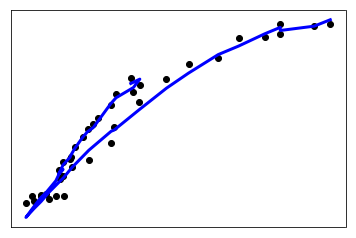

In [198]:
train_x = train_x['construction_workers']
plt.scatter(train_x, train_y, color='black')
plt.plot(train_x, pred_y_train, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

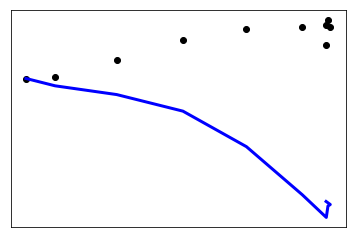

In [199]:
test_x = test_x['construction_workers']
plt.scatter(test_x, test_y, color='black')
plt.plot(test_x, pred_y_test, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

Para dibujar el ajuste se va a tener en cuenta la variable *construction_workers*, que es una de las más importantes. Se puede ver como el ajuste en el conjunto de entrenamiento es muy bueno pero en el conjunto de test es realmente malo ya que la predicción se aleja mucho de los puntos reales. 

In [221]:
X = df.drop(['property_price_index'], axis=1)
X_cols = X.columns.tolist()
X = RobustScaler().fit_transform(X)
y = df['property_price_index']
train_x, test_x, train_y, test_y = train_test_split(X, y, shuffle=False, test_size=0.20)
lasso_regressor = Lasso(alpha = 2.10, random_state=1).fit(train_x, train_y)
pred_y_train = lasso_regressor.predict(train_x)
pred_y_test = lasso_regressor.predict(test_x)

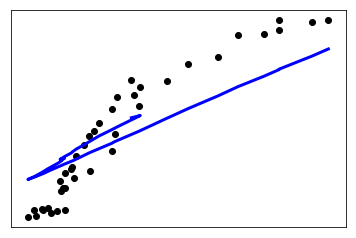

In [222]:
train_x = train_x[:,5]
plt.scatter(train_x, train_y, color='black')
plt.plot(train_x, pred_y_train, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

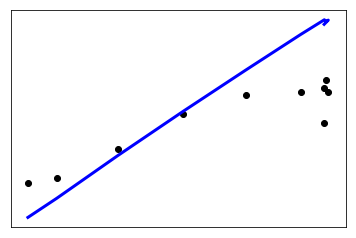

In [223]:
test_x = test_x[:,5]
plt.scatter(test_x, test_y, color='black')
plt.plot(test_x, pred_y_test, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

En este caso, se puede ver como el ajuste en entrenamiento no es tan preciso, y en test la predicción coge una buena trayectoria. De este modo, se puede ver la diferencia clara entre ambos modelos.